##**1. Pra-pemrosesan Data**

Tahapan pra-pemrosesan ini bertujuan untuk menyiapkan data agar dapat digunakan oleh model clustering. Proses ini meliputi:

* Menghapus kolom yang tidak relevan
* Menghapus nilai kosong
* Seleksi fitur berdasarkan variansi
* Menghapus fitur duplikat atau berkorelasi tinggi
* Melakukan standarisasi data

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/content/sample_data/UTSClustering.csv', encoding='ISO-8859-1')

# Menghapus kolom yang tidak relevan jika ada
df.drop(columns=[col for col in ['Time', 'Class'] if col in df.columns], inplace=True)

# Menghapus baris yang mengandung nilai kosong
df.dropna(inplace=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


##**Seleksi Fitur**

Beberapa fitur mungkin tidak memberikan informasi penting (variansi terlalu rendah) atau sangat mirip dengan fitur lain (korelasi tinggi atau duplikat). Langkah ini bertujuan untuk mempertahankan fitur yang relevan.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# --- Asumsi df sudah dimuat sebelumnya ---

# Hapus kolom non-numerik
df = df.select_dtypes(include=[np.number])

# Hapus fitur dengan variansi rendah
vt = VarianceThreshold(threshold=0.01)
df = df[df.columns[vt.fit(df).get_support()]]

# Hapus fitur duplikat
df = df.loc[:, ~df.T.duplicated()]

# Hapus fitur dengan korelasi sangat tinggi (> 0.95)
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
df.drop(columns=to_drop, inplace=True)

# Standarisasi
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

##**2. Model Clustering dan Evaluasi**

Beberapa algoritma clustering digunakan untuk mengeksplorasi struktur data:

* KMeans
* Agglomerative Clustering
* DBSCAN
* Gaussian Mixture
* Spectral Clustering

Evaluasi dilakukan dengan tiga metrik:

* Silhouette Score
* Davies-Bouldin Index
* Calinski-Harabasz Score

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Fungsi evaluasi model
def evaluate_model(name, model, data):
    labels = model.fit_predict(data)
    return {
        'Model': name,
        'Labels': labels,
        'Silhouette': silhouette_score(data, labels),
        'DBI': davies_bouldin_score(data, labels),
        'CH': calinski_harabasz_score(data, labels)
    }

# Dictionary model
models = {
    'KMeans': KMeans(n_clusters=5, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=5),
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5),
    'GaussianMixture': GaussianMixture(n_components=5, random_state=42),
    'SpectralClustering': SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors')
}

# Jalankan semua model secara berurutan
results = []
for name, model in models.items():
    try:
        result = evaluate_model(name, model, scaled_df)
        results.append(result)
    except Exception as e:
        print(f"Model {name} gagal dieksekusi: {e}")

# Ubah ke DataFrame
results_df = pd.DataFrame(results).set_index('Model')
results_df.sort_values('Silhouette', ascending=False, inplace=True)

# Tampilkan hasil
print(results_df)

##**Penjelasan Metrik Evaluasi**
* Silhouette Score: Mengukur seberapa baik suatu titik berada dalam cluster-nya dibandingkan dengan cluster lain. Semakin tinggi nilainya, semakin baik.
* Davies-Bouldin Index: Rasio antar jarak dalam cluster dan antar cluster. Semakin kecil nilainya, semakin baik.
* Calinski-Harabasz Score: Perbandingan variansi antar dan dalam cluster. Semakin besar, semakin baik.

Silhouette Score digunakan sebagai indikator utama dalam menilai kualitas clustering.

##**3. Visualisasi Clustering**

Visualisasi dilakukan menggunakan PCA untuk mereduksi dimensi menjadi 2 agar dapat diplot dalam bentuk scatter plot. Selain itu, dendrogram juga ditampilkan untuk menggambarkan hasil Agglomerative Clustering.

NameError: name 'results' is not defined

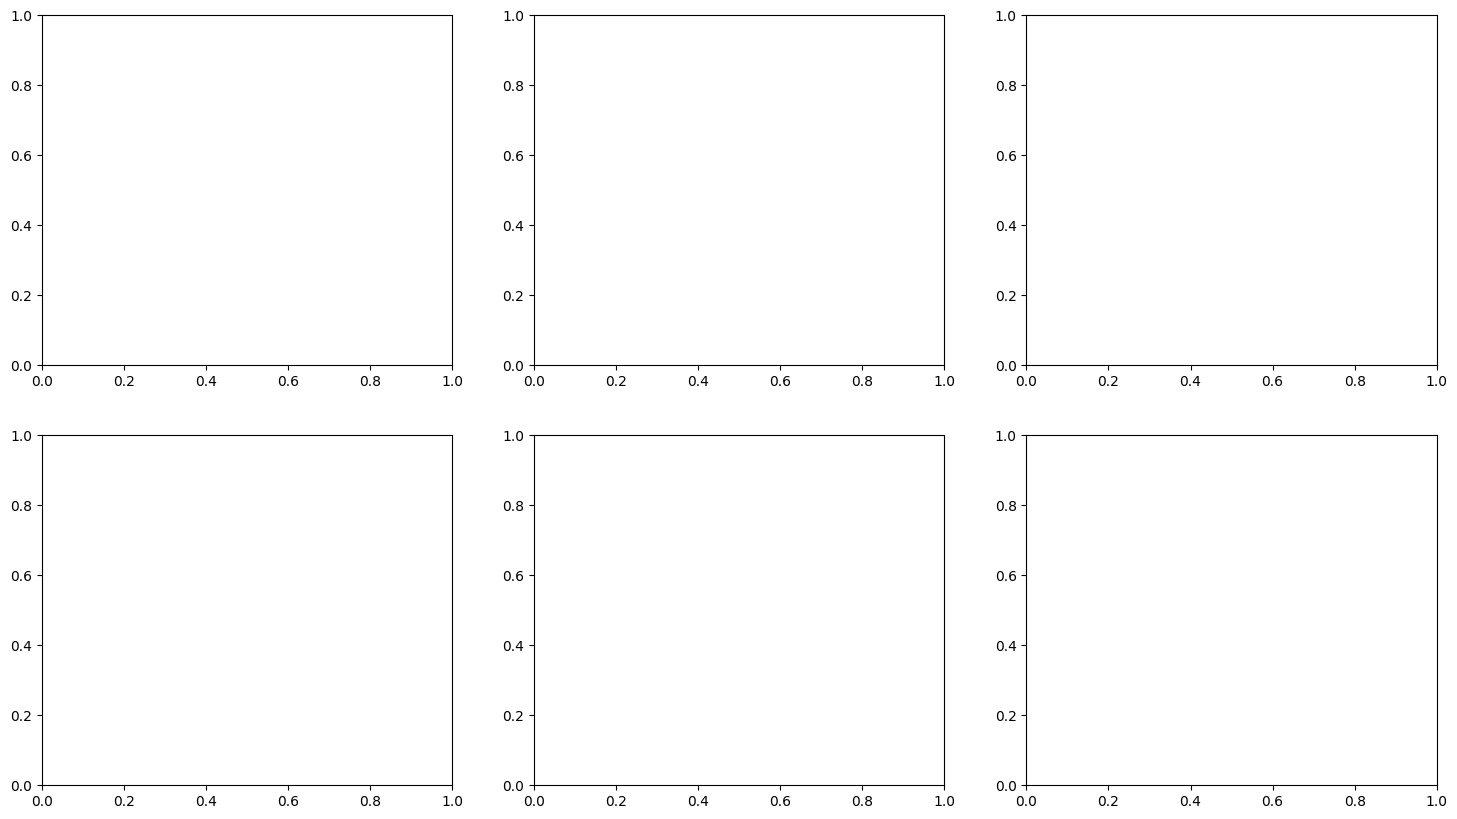

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# PCA scatter
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, model_result) in enumerate(results.items()):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(scaled_df)
    axes[idx].scatter(reduced[:, 0], reduced[:, 1], c=model_result['Labels'], cmap='Set1')
    axes[idx].set_title(f'{name} Clusters')

plt.tight_layout()
plt.show()

# Dendrogram untuk Agglomerative
linked = linkage(scaled_df, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Agglomerative Dendrogram')
plt.tight_layout()
plt.show()

##**4. Analisis Tambahan dan Interpretasi**
**Q1: Inkonstensi KMeans dan Silhouette Score**

Elbow method fokus pada penurunan inertia, bukan kualitas cluster secara struktur. Silhouette Score rendah meski K optimal menunjukkan bentuk cluster tidak spherikal atau terjadi overlap.

**Q2: Preprocessing Fitur Campuran (Numerik dan Kategorikal)**

One-Hot Encoding untuk fitur teks seperti Description bisa menghasilkan dimensi tinggi dan sparce. Solusi alternatif: TF-IDF atau embedding seperti UMAP.

**Q3: Penentuan Epsilon pada DBSCAN**

Gunakan k-distance graph untuk menentukan eps, biasanya dari elbow atau kuartil ke-3. MinPts harus disesuaikan dengan kepadatan data dan jumlah fitur.

**Q4: Overlap antara High-Value dan Bulk Buyers**

Solusi dapat berupa constrained clustering (semi-supervised) atau metric learning seperti Mahalanobis Distance. Tantangannya adalah menjaga interpretabilitas hasil.

**Q5: Fitur Temporal dan Risiko Data Leakage**

Gunakan fitur waktu seperti hari, jam, akhir pekan. Hindari aggregasi waktu tanpa validasi berdasarkan waktu. Fitur lag (misal pembelian 7 hari sebelumnya) dapat menimbulkan noise.

Model dengan Silhouette Score tertinggi menjadi kandidat terbaik. Namun, hasil akhir juga perlu mempertimbangkan bentuk cluster, noise, dan kebutuhan interpretasi bisnis.